In [25]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np


# Load the iris dataset
df = pd.read_csv('./iris.data', header=None)

# Establish a numberical mapping of the label classes
labels = {
    'Iris-setosa' : 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2,
}

# Split the dataframe in to feature and label datasets
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].map(labels).to_numpy()

In [26]:
# PCA decomposition
def pca(X, k=None):
    # Calculate the mean of the training features
    M = np.mean(X, axis=0)

    # Perform SVD on the centred training dataset
    U, S, V = np.linalg.svd(X - M, full_matrices=True)

    # PCA
    W = V
    D = np.zeros(X.shape)
    np.fill_diagonal(D, S)
    Z = U @ D

    # Return the mean of the training features, the principle components and the projected training dataset
    if k:
        return M, W[:k], Z[:,:k]
    else:
        return M, W, Z


# Identify the top 2 principle components in the dataset 
_, _, Z = pca(X, k=2)

[]

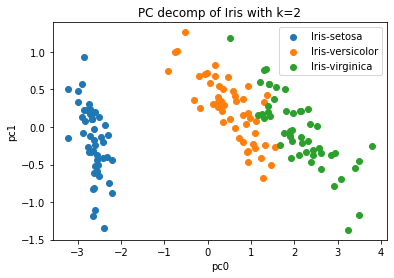

In [27]:

# Plot the decomposition of the data with the top 2 PCs
for label_name, label_id in labels.items():
    C = Z[np.where(y == label_id)]
    plt.scatter(C[:,0], C[:,1], label=label_name)

plt.title('PC decomp of Iris with k=2')
plt.xlabel('pc0')
plt.ylabel('pc1')
plt.legend(loc='upper right')
plt.plot()

In [28]:

# Multi-class linear regression classifier model
class Perceptron:

    def __init__(self, X, y, itrs=50):
        # Prepend a bias column to the dataset
        X = np.hstack((np.ones((len(X),1)), X))

        # Train the regression weights
        self.W = self.train(X, y, itrs)


    def train(self, X, y, itrs=50):
        # Determine the shape of the weight matrix 
        classes = len(np.unique(y))
        dimensions = X.shape[1]

        # Initialise the weights
        W = np.zeros((classes, dimensions))

        # Iteratively fit the weights
        for i in range(0, itrs):
            # Copy the weights
            W_ = np.copy(W)

            # Shuffle the training data
            X, y = shuffle(X, y, random_state=0)

            # Iterate through all feature-class pairs
            for x_i, y_i in zip(X, y):

                # Predict the class
                y_p = np.argmax(np.dot(W, x_i), axis=0)

                # Adjust the new weights if the prediction is wrong
                if y_p != y_i:
                    W_[y_i] += x_i
                    W_[y_p] -= x_i

            # Copy back the new weights
            W = W_
        
        # Return the weights
        return W
    

    def predict(self, X):
        # Prepend a bias column to the dataset
        X = np.hstack((np.ones((len(X),1)), X))

        # Return the class index with the max predicted value
        return np.argmax(X @ self.W.T, axis=1)


    def errors(self, X, y):
        # Predict the dataset classes
        y_ = self.predict(X)

        # Compare the prediction and ground classes
        return np.sum(y != y_)


    def accuracy(self, X, y):
        # Predict the dataset classes
        y_ = self.predict(X)

        # Compare the prediction and ground classes
        return np.sum(y == y_) / len(y)
          


# Execute on the 2D projection
m1 = Perceptron(Z, y)
print('2D Projection: ', m1.accuracy(Z, y))

# Execute on the raw
m2 = Perceptron(X, y)
print('No Projection: ', m2.accuracy(X, y))

# Execute on the 4D projection
_, _, Z = pca(X)
m3 = Perceptron(Z, y)
print('4D Projection: ', m3.accuracy(Z, y))

2D Projection:  0.9666666666666667
No Projection:  0.9133333333333333
4D Projection:  0.9866666666666667


In [29]:
# Gaussian kernel
def rbgKernel(X, gam):
    # Compute kernel
    K = np.exp(-gam * np.linalg.norm(X[:,:,None]-X.T[None,:,:], ord=2, axis=1)) 

    # Form matrix A
    A = np.full(K.shape, 1 / len(X))

    # Normalise and return the kernel
    return K - A @ K - K @ A + (A @ K) @ A


# Determine gamma range
X_centred = X - np.mean(X, axis=0)
var = X_centred.var(axis=0)
eps = 0.05
gam_min = 0.5 / (var.max() + eps)
gam_max = 0.5 / (var.min() - eps)
gam_range = np.arange(gam_min, gam_max, 0.10)
k_range = np.arange(X.shape[1]+1, X.shape[0]+1, 1)


# Reduce grid size (for faster development)
# k_range = k_range[0:10]
# gam_range = gam_range[:20]


# Create a table to store the error of each model
model_errors = np.empty((len(k_range), len(gam_range)))


# Iterate over gamma values 
for j, gam in enumerate(gam_range):
    # Compute the kernel
    K = rbgKernel(X, gam)
    _, W, Z = pca(K)

    # Try the top k components between d and n
    for i, k in enumerate(k_range):
        # Select the top k components from the decomposition
        Z_ = Z[:,:k]

        # Train a model with the parameters
        m = Perceptron(Z_, y)

        # Record the models number of training errors
        model_errors[i, j] = m.errors(Z_, y)


In [30]:
# Select the k-gam pair which produces the least training errors in the error grid
i, j = np.unravel_index(model_errors.argmin(), model_errors.shape)
k = k_range[i]
gam = gam_range[j]

# Reconstruct the best model with the tuned parameters
K = rbgKernel(X, gam)
_, _, Z = pca(K, k=k)
m = Perceptron(Z, y) 

# Print the model performance
print('k:', k, 'gam:', gam, 'acc:', m.accuracy(Z, y))

k: 76 gam: 3.4591127927251097 acc: 1.0


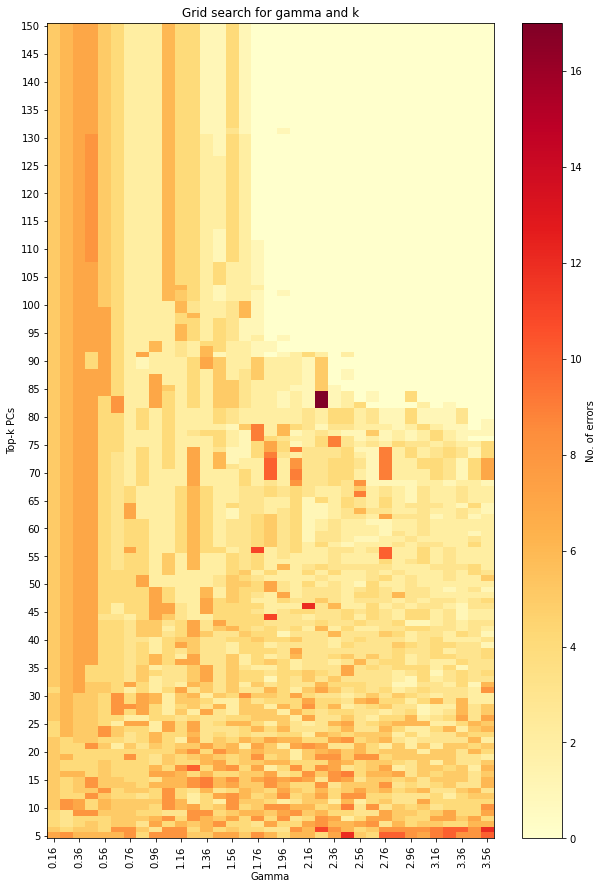

In [31]:
# Plot the grid search
fig, ax = plt.subplots(figsize=(10, 15))
im = ax.imshow(model_errors, aspect='auto', interpolation='nearest', cmap='YlOrRd')
cb = fig.colorbar(im, ax=ax)
cb.set_label('No. of errors')
plt.xticks(np.arange(0, len(gam_range), 2), np.round(gam_range[::2], 2), rotation=90)
plt.yticks(np.arange(0, len(k_range), 5), k_range[::5])
plt.gca().invert_yaxis()
plt.title('Grid search for gamma and k')
plt.xlabel('Gamma')
plt.ylabel('Top-k PCs')
plt.show()